In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import joblib
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
# Preset parameters
RANDOM_SEED = 42
VALIDATE_SIZE = 0.2

# Setting random seeds to ensure reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

In [3]:
# Define patients and their corresponding files
patients = {
    1: ['Data/organized_fcs_data1a.csv', 'Data/organized_fcs_data1b.csv', 'Data/organized_fcs_data1c.csv'],
    2: ['Data/organized_fcs_data2a.csv', 'Data/organized_fcs_data2b.csv', 'Data/organized_fcs_data2c.csv'],
    3: ['Data/organized_fcs_data3a.csv', 'Data/organized_fcs_data3b.csv', 'Data/organized_fcs_data3c.csv'],
    4: ['Data/organized_fcs_data4a.csv', 'Data/organized_fcs_data4b.csv', 'Data/organized_fcs_data4c.csv'],
    5: ['Data/organized_fcs_data5a.csv', 'Data/organized_fcs_data5b.csv', 'Data/organized_fcs_data5c.csv'],
    6: ['Data/organized_fcs_data6a.csv', 'Data/organized_fcs_data6b.csv', 'Data/organized_fcs_data6c.csv'],
    7: ['Data/organized_fcs_data7.csv'],
    8: ['Data/organized_fcs_data8a.csv', 'Data/organized_fcs_data8b.csv', 'Data/organized_fcs_data8c.csv'],
    9: ['Data/organized_fcs_data9a.csv', 'Data/organized_fcs_data9b.csv'],
    10: ['Data/organized_fcs_data10a.csv', 'Data/organized_fcs_data10b.csv', 'Data/organized_fcs_data10c.csv'],
    11: ['Data/organized_fcs_data11.csv'],
    12: ['Data/organized_fcs_data12a.csv', 'Data/organized_fcs_data12b.csv', 'Data/organized_fcs_data12c.csv']
} 

In [4]:
import random
import pandas as pd

training_dfs = []
testing_dfs = []

first_six_ids = list(patients.keys())[:6]
training_ids = set(random.sample(first_six_ids, 5))

for patient_id, file_paths in patients.items():
    # Load all three CSV files for the patient and drop the "Time" column
    patient_data = pd.concat([pd.read_csv(file).drop(columns=['Time'], errors='ignore') for file in file_paths])
    
    if patient_id in training_ids:
        training_dfs.append(patient_data)
    else:
        testing_dfs.append(patient_data)

train_full = pd.concat(training_dfs, ignore_index=True)
test_full = pd.concat(testing_dfs, ignore_index=True)

In [5]:
print(training_ids)

{1, 2, 3, 5, 6}


In [6]:
print(f"Training data samples: {len(training_dfs)}")
print(f"Testing data samples: {len(testing_dfs)}")

Training data samples: 5
Testing data samples: 7


In [12]:
# full_dataset = pd.concat(sampled_dfs)# Concatenate all sampled dataframes into a single dataframe


In [11]:
# # Shuffle the data
# shuffled_dataset = full_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# # Split into training (80%) and validation (20%)
# train_df, val_df = train_test_split(shuffled_dataset, test_size=0.2, random_state=42)

In [7]:
# Save the splits
train_full.to_csv('training_data.csv', index=False)
test_full.to_csv('validation_data.csv', index=False)   #me

# # Print summary
# print(f"Total dataset size: {len(train_full)} cells")
print(f"Training set size: {len(train_full)} cells")
print(f"Validation set size: {len(test_full)} cells")   #me

Training set size: 23448575 cells
Validation set size: 24427497 cells


In [8]:
# configure our pipeline
pipeline = Pipeline([('scaler', MinMaxScaler())])
pipeline.fit(train_full)

Pipeline(steps=[('scaler', MinMaxScaler())])

In [9]:
# Save the pipeline to a file
joblib.dump(pipeline, 'April_pipeline.pkl')

['April_pipeline.pkl']

In [10]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(train_full)
X_validate_transformed = pipeline.transform(test_full)   #me

In [11]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [12]:
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = torch.tensor(dataset, dtype=torch.float32)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

In [13]:
train_dataset = CustomDataset(X_train_transformed)
val_dataset = CustomDataset(X_validate_transformed)    #me

In [14]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)    #me

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        # Defining the Encoder
        self.encoder=nn.Sequential(
            # Input_dim -> 16 -> 8 -> 4 -> 2
            nn.Linear(input_dim, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Linear(8, 4),
            nn.ELU(),
            # nn.Linear(4, 2),
            # nn.ELU()
        )
        
        # Defining the Decoder
        self.decoder = nn.Sequential(
            # 2 -> 4 -> 8 -> 16 -> Input_dim
            # nn.Linear(2, 4),
            # nn.ELU(),
            nn.Linear(4, 8),
            nn.ELU(),
            nn.Linear(8, 16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
autoencoder= AutoEncoder(input_dim=input_dim)

In [17]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())

In [18]:
# Print model summary
print(autoencoder)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=14, bias=True)
    (5): ELU(alpha=1.0)
  )
)


In [19]:
def train_autoencoder(model, train_loader, val_loader, epochs=100, lr=0.001):
    
    # Setup
    device = torch.device('cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training trackers
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    print(f"Training autoencoder for {epochs} epochs...")
    print("-" * 50)
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training
        model.train()
        train_loss = 0.0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(device)
                reconstructed = model(batch_data)
                loss = criterion(reconstructed, batch_data)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {avg_train_loss:.6f} | "
              f"Val: {avg_val_loss:.6f} | Time: {epoch_time:.1f}s | "
              f"Patience: {patience_counter}/{patience}")
        
        # Stop if patience exceeded
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            model.load_state_dict(best_model)
            break
    
    print("Training completed!")
    return model, train_losses, val_losses

# Usage
def run_training():
    # Initialize model
    autoencoder = AutoEncoder(input_dim=input_dim)
    print(f"Model created with {sum(p.numel() for p in autoencoder.parameters())} parameters")
    
    # Train
    trained_model, train_history, val_history = train_autoencoder(
        model=autoencoder,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        lr=0.001
    ) 

    # Save the trained model
    torch.save(trained_model.state_dict(), 'autoencoder_model.pth')
    print("Model saved to autoencoder_model.pth")
    
    return trained_model, train_history, val_history

# Run training
if __name__ == "__main__":
    trained_model, train_losses, val_losses = run_training()

Model created with 834 parameters
Training autoencoder for 100 epochs...
--------------------------------------------------
Epoch   1/100 | Train: 0.002220 | Val: 0.003082 | Time: 133.3s | Patience: 0/15
Epoch   2/100 | Train: 0.001896 | Val: 0.003031 | Time: 121.8s | Patience: 0/15
Epoch   3/100 | Train: 0.001843 | Val: 0.003006 | Time: 114.6s | Patience: 0/15
Epoch   4/100 | Train: 0.001817 | Val: 0.002970 | Time: 116.4s | Patience: 0/15
Epoch   5/100 | Train: 0.001804 | Val: 0.002938 | Time: 117.7s | Patience: 0/15
Epoch   6/100 | Train: 0.001789 | Val: 0.002880 | Time: 114.4s | Patience: 0/15
Epoch   7/100 | Train: 0.001770 | Val: 0.002894 | Time: 113.4s | Patience: 1/15
Epoch   8/100 | Train: 0.001755 | Val: 0.002894 | Time: 113.5s | Patience: 2/15
Epoch   9/100 | Train: 0.001741 | Val: 0.002878 | Time: 114.9s | Patience: 0/15
Epoch  10/100 | Train: 0.001728 | Val: 0.002924 | Time: 113.9s | Patience: 1/15
Epoch  11/100 | Train: 0.001715 | Val: 0.002998 | Time: 117.6s | Patience: 2

In [ ]:
# Validation loss with last layer size 2 : 0.004675(44 epochs early stopping)
# Validation loss with last layer size 4 : 0.002878(24 epochs early stopping)

In [20]:
def calculate_mse_per_row(model, pipeline_path, patient_id, device='cpu'):
    pipeline = joblib.load(pipeline_path)
    
    # Collect file paths
    file_paths = patients[patient_id]
    
    # Load and preprocess data
    df = pd.concat([pd.read_csv(file).drop(columns=['Time'], errors='ignore') for file in file_paths])
    transformed_data = pipeline.transform(df)

    # Convert to tensor
    model.to(device)
    model.eval()
    data_tensor = torch.tensor(transformed_data, dtype=torch.float32).to(device)

    # Compute reconstruction and MSE
    with torch.no_grad():
        reconstructed = model(data_tensor)
        mse = torch.mean((data_tensor - reconstructed) ** 2, dim=1).cpu().numpy()
    
    # Store in a new DataFrame
    df_mse = df.copy()
    df_mse['MSE'] = mse

    # Save the file
    output_path = f"patient_{patient_id}_mse.csv"
    df_mse.to_csv(output_path, index=False)

    print(f"MSE values for Patient {patient_id} saved to {output_path}")
    return mse, df_mse


In [27]:
# Example: Calculate MSE for Patient No (unhealthy)
mse_values, df_with_mse = calculate_mse_per_row(trained_model, 'April_pipeline.pkl', patient_id=12)

# View MSE thresholding logic
percent_unhealthy = 4.2
threshold_index = int((percent_unhealthy / 100) * len(mse_values))
threshold_value = np.sort(mse_values)[-threshold_index]

print(f"\nThreshold for top {percent_unhealthy}% reconstruction errors: {threshold_value:.5f}")

MSE values for Patient 12 saved to patient_12_mse.csv

Threshold for top 4.2% reconstruction errors: 0.01019


In [ ]:
##### Layer 2

#MSE values for Patient 7 saved to patient_7_mse.csv
#Threshold for top 3.28% reconstruction errors: 0.01916

# MSE values for Patient 8 saved to patient_8_mse.csv
# Threshold for top 1.2% reconstruction errors: 0.01492

# MSE values for Patient 9 saved to patient_9_mse.csv
# Threshold for top 9.3% reconstruction errors: 0.01968

# MSE values for Patient 10 saved to patient_10_mse.csv
# Threshold for top 2.17% reconstruction errors: 0.02000

# MSE values for Patient 11 saved to patient_11_mse.csv
# Threshold for top 14.6% reconstruction errors: 0.01591

# MSE values for Patient 12 saved to patient_12_mse.csv
# Threshold for top 4.2% reconstruction errors: 0.01407

In [ ]:
##### Layer 4

# MSE values for Patient 7 saved to patient_7_mse.csv
# Threshold for top 3.28% reconstruction errors: 0.01303

# MSE values for Patient 8 saved to patient_8_mse.csv
# Threshold for top 1.2% reconstruction errors: 0.00954

# MSE values for Patient 9 saved to patient_9_mse.csv
# Threshold for top 9.3% reconstruction errors: 0.01052

# MSE values for Patient 10 saved to patient_10_mse.csv
# Threshold for top 2.17% reconstruction errors: 0.01714

# MSE values for Patient 11 saved to patient_11_mse.csv
# Threshold for top 14.6% reconstruction errors: 0.00992

# MSE values for Patient 12 saved to patient_12_mse.csv
# Threshold for top 4.2% reconstruction errors: 0.01019

In [39]:
#Average threshold  for layer 2
thresholds = [0.01916, 0.01492, 0.01968, 0.02000, 0.01591, 0.01407]
avg_threshold = np.mean(thresholds)

print(f"Average threshold from patients 7 to 12: {avg_threshold:.5f}")

Average threshold from patients 7 to 12: 0.01729


In [42]:
#Average threshold  for layer 4
thresholds = [0.01303, 0.00954, 0.01052, 0.01714, 0.00992, 0.01019]
avg_threshold = np.mean(thresholds)

print(f"Average threshold from patients 7 to 12: {avg_threshold:.5f}")


Average threshold from patients 7 to 12: 0.01172


In [49]:
import pandas as pd
import numpy as np

# Step 2: Load Patient with MSE column
df = pd.read_csv('patient_12_mse.csv') 

# Extract MSE values
mse_values = df['MSE'].values

# Use average threshold
threshold = avg_threshold
print(threshold)

# Calculate % of cells above threshold
num_above = np.sum(mse_values > threshold)
total = len(mse_values)
percent_above = (num_above / total) * 100

print(f"{percent_above:.2f}% of cells in Patient have reconstruction error > {threshold:.5f}")

0.011723333333333334
3.07% of cells in Patient have reconstruction error > 0.01172


In [ ]:
#layer with size 2

# 4.24% of cells in Patient 7 have reconstruction error > 0.01729
# 0.90% of cells in Patient 8 have reconstruction error > 0.01729
# 10.21% of cells in Patient 9 have reconstruction error > 0.01729
# 2.67% of cells in Patient 10 have reconstruction error > 0.01729
# 13.11% of cells in Patient 11 have reconstruction error > 0.01729
# 2.81% of cells in Patient 12 have reconstruction error > 0.01729

In [ ]:
#layer with size 4

# 4.56% of cells in Patient 7 have reconstruction error > 0.01172
# 0.78% of cells in Patient 8 have reconstruction error > 0.01172
# 8.20% of cells in Patient 9 have reconstruction error > 0.01172
# 2.91% of cells in Patient 10 have reconstruction error > 0.01172
# 12.05% of cells in Patient 11 have reconstruction error > 0.01172
# 3.07% of cells in Patient 12 have reconstruction error > 0.01172

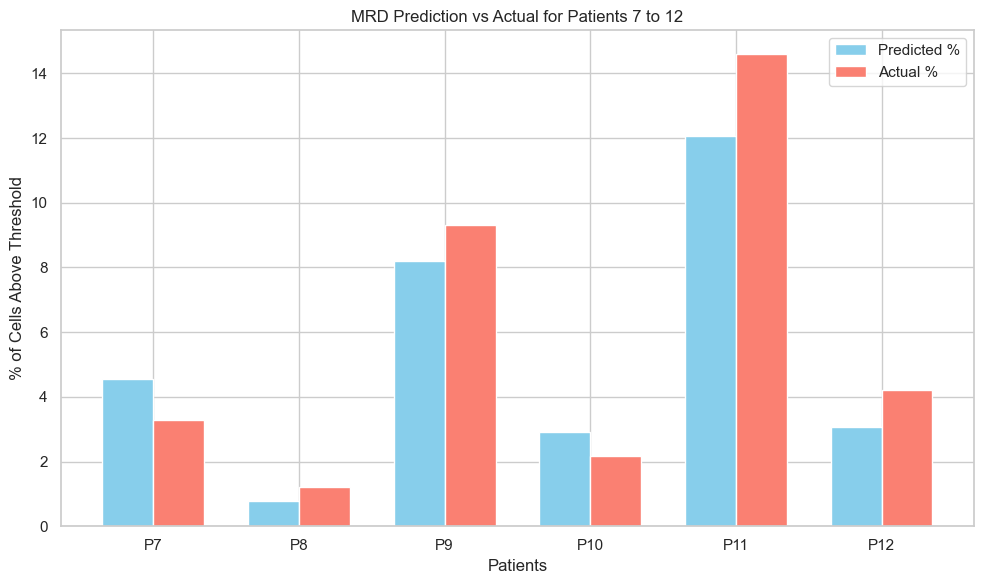

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Patient IDs
patients = ['P7', 'P8', 'P9', 'P10', 'P11', 'P12']

# Predicted percentages by model
predicted_percentages = [4.56, 0.78, 8.20, 2.91, 12.05, 3.07]

# Actual ground truth percentages
actual_percentages = [3.28, 1.2, 9.3, 2.17, 14.6, 4.2]

# Create a DataFrame for visualization
df_plot = pd.DataFrame({
    'Patient': patients,
    'Predicted': predicted_percentages,
    'Actual': actual_percentages
})

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot bars
bar_width = 0.35
x = np.arange(len(patients))
plt.bar(x - bar_width/2, df_plot['Predicted'], bar_width, label='Predicted %', color='skyblue')
plt.bar(x + bar_width/2, df_plot['Actual'], bar_width, label='Actual %', color='salmon')

# Add labels and legend
plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('MRD Prediction vs Actual for Patients 7 to 12')
plt.xticks(ticks=x, labels=patients)
plt.legend()
plt.tight_layout()
plt.show()


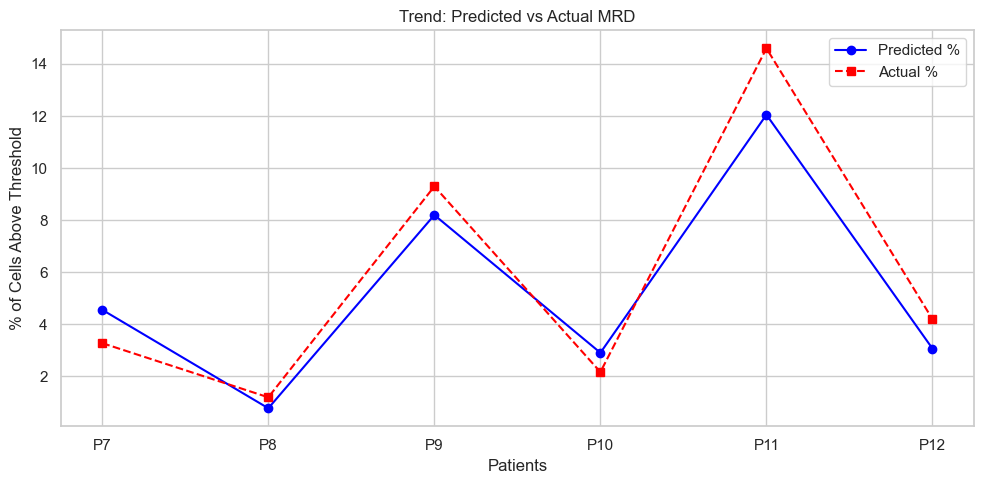

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(patients, predicted_percentages, marker='o', label='Predicted %', linestyle='-', color='blue')
plt.plot(patients, actual_percentages, marker='s', label='Actual %', linestyle='--', color='red')

plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('Trend: Predicted vs Actual MRD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/bd/9ft36zdj2zj1l_tnnp4gt6_80000gn/T/ipykernel_9932/2975713109.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patients, y=errors, palette='viridis')


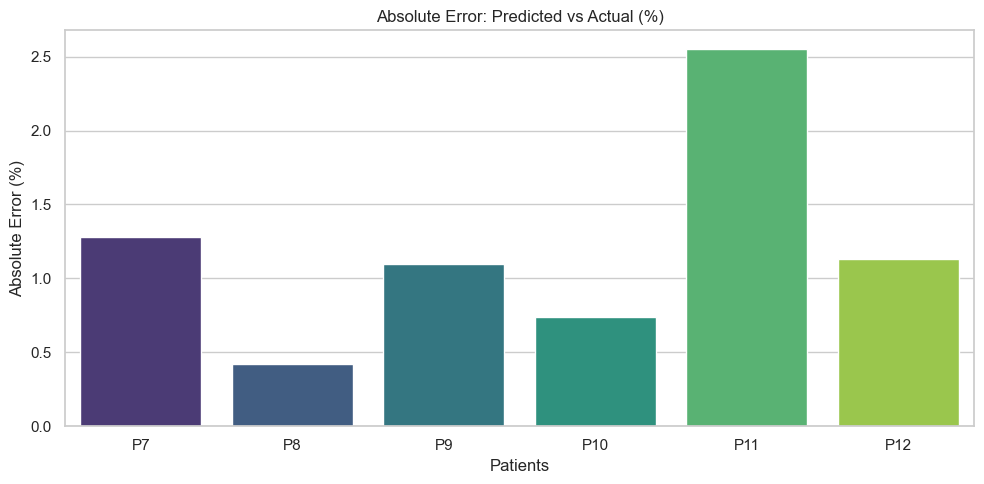

In [53]:
errors = [abs(p - a) for p, a in zip(predicted_percentages, actual_percentages)]

plt.figure(figsize=(10, 5))
sns.barplot(x=patients, y=errors, palette='viridis')

plt.title('Absolute Error: Predicted vs Actual (%)')
plt.xlabel('Patients')
plt.ylabel('Absolute Error (%)')
plt.tight_layout()
plt.show()